# Problema de Fluxo Máximo (PFM)

In [1]:
import cplex
import networkx as nx
import matplotlib.pyplot as plt

## Leitura e pré-processamento dos dados

In [21]:
file = "in_pfm.txt"

with open(file, 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = list(filter(None, lines))

num_nodes, num_edges = map(int, lines[0].strip().split())
s, t = map(int, lines[1].strip().split())

arcs = {}
for line in lines[2:]:
    node1, node2, capacity = map(int, line.strip().split())
    arcs[(node1, node2)] = capacity

arcs

{(0, 1): 8,
 (0, 2): 18,
 (1, 4): 12,
 (1, 3): 4,
 (1, 2): 10,
 (2, 3): 5,
 (2, 5): 10,
 (3, 4): 7,
 (3, 5): 14,
 (4, 6): 20,
 (5, 6): 6}

## Visualização do problema

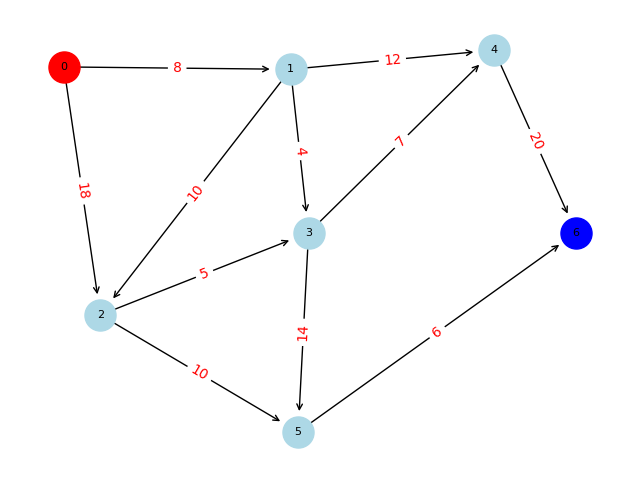

In [22]:
G = nx.DiGraph()

G.add_nodes_from(range(num_nodes))

for (u, v), cost in arcs.items():
    G.add_edge(u, v, weight=cost)

pos = nx.spring_layout(G, k=1.0, iterations=50)

path_nodes = [node for node in G.nodes() if node not in [s, t]]
node_labels = {i: f'{i}' for i in G.nodes}
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, nodelist=[s], node_color='red', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=[t], node_color='blue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, min_target_margin = 15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.axis('off')
plt.show()

## Modelagem e solução

In [48]:
model = cplex.Cplex()
model.set_problem_type(cplex.Cplex.problem_type.LP)
model.objective.set_sense(model.objective.sense.maximize)

# Adiciona variáveis de decisão para cada aresta com capacidade como limite superior
edge_names = []
for (i, j), capacity in arcs.items():
    var_name = f"x_{i}_{j}"
    model.variables.add(names=[var_name], lb=[0], ub=[capacity])
    edge_names.append(var_name)

# Adiciona restrições de conservação de fluxo para cada nó
for node in range(num_nodes):
    if node == s or node == t:
        continue
    inflow = [f"x_{i}_{node}" for i in range(num_nodes) if (i, node) in arcs]
    outflow = [f"x_{node}_{j}" for j in range(num_nodes) if (node, j) in arcs]
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(inflow + outflow, [1] * len(inflow) + [-1] * len(outflow))],
        senses=["E"],
        rhs=[0]
    )

# Define a função objetivo: maximizar o fluxo que sai da origem
outflow_source = [f"x_{s}_{j}" for j in range(num_nodes) if (s, j) in arcs]
model.objective.set_linear([(var, 1) for var in outflow_source])

%time model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 1 rows and 3 columns.
Reduced LP has 4 rows, 8 columns, and 13 nonzeros.
Presolve time = 0.01 sec. (0.01 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            23.000000


CPU times: user 14.7 ms, sys: 9.47 ms, total: 24.1 ms
Wall time: 21.5 ms


## Sumário dos resultados

In [47]:
print("Status da solução:", model.solution.get_status_string())
print(f"Fluxo máximo: {model.solution.get_objective_value()}")

model.write("./output/model_pfm.lp")
model.solution.write("./output/solution_pfm.sol")


Default row names c1, c2 ... being created.


Status da solução: optimal
Fluxo máximo: 19.0
